**Loading data**

In [1]:
!pip install fuzzywuzzy
!pip install python-Levenshtein


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from prettytable import PrettyTable
from dateutil import parser
from geopy.distance import geodesic
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

In [3]:
books = pd.read_csv('data/books.csv')
checkouts = pd.read_csv('data/checkouts.csv')
customers = pd.read_csv('data/customers.csv')
libraries = pd.read_csv('data/libraries.csv')

**Data Cleaning**

1- Standardizing the wods using scikit-learn and clustering for extraction of similar words in Education, Gender, State, Occupation, and so on.

In [4]:
def extract_keywords(column, num_clusters=4):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(column.dropna().astype(str))
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)
    
    clusters = {}
    for i in range(num_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        terms = vectorizer.get_feature_names_out()
        sorted_terms = [terms[ind] for ind in cluster_center.argsort()[-10:]]
        clusters[i] = sorted_terms
    return clusters

List of extracted standard words using scikit-learn

In [5]:
standard_education = extract_keywords(customers['education'])
standard_gender = extract_keywords(customers['gender'], num_clusters=2)
standard_state = extract_keywords(customers['state'], num_clusters=3)
standard_occupation = extract_keywords(customers['occupation'], num_clusters=4)

print("Standard Education Keywords:", standard_education)
print("Standard Gender Keywords:", standard_gender)
print("Standard State Keywords:", standard_state)
print("Standard Occupation Keywords:", standard_occupation)


Standard Education Keywords: {0: ['college', 'high', 'others', 'school', 'degree', 'graduate'], 1: ['college', 'degree', 'graduate', 'others', 'high', 'school'], 2: ['degree', 'graduate', 'high', 'others', 'school', 'college'], 3: ['college', 'degree', 'graduate', 'high', 'school', 'others']}
Standard Gender Keywords: {0: ['female', 'male'], 1: ['male', 'female']}
Standard State Keywords: {0: ['washington', 'oregon'], 1: ['oregon', 'washington'], 2: ['washington', 'oregon']}
Standard Occupation Keywords: {0: ['health', 'others', 'tech', 'business', 'finance', 'blue', 'collar', 'admin', 'support', 'sales'], 1: ['blue', 'business', 'collar', 'education', 'finance', 'health', 'sales', 'support', 'tech', 'others'], 2: ['blue', 'business', 'collar', 'finance', 'others', 'sales', 'support', 'tech', 'education', 'health'], 3: ['blue', 'business', 'collar', 'education', 'finance', 'health', 'others', 'sales', 'support', 'tech']}


C:\Users\iwont\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Standardizing the words using fuzzy logic.

In [6]:
#Function for Fuzzy matching method to map the values
def fuzzy_map_automated(column, standard_dict):
    standard_list_flat = [item for sublist in standard_dict.values() for item in sublist]
    mapped_values = column.apply(lambda x: process.extractOne(x, standard_list_flat)[0] if pd.notnull(x) else x)
    return mapped_values

customers['education'] = fuzzy_map_automated(customers['education'], standard_education)
customers['gender'] = fuzzy_map_automated(customers['gender'], standard_gender)
customers['state'] = fuzzy_map_automated(customers['state'], standard_state)
customers['occupation'] = fuzzy_map_automated(customers['occupation'], standard_occupation)


Manual standardization of words to improve previous methods. 

In [7]:
standard_education = ['Graduate Degree', 'High School', 'College', 'Others']
standard_gender = ['Female', 'Male']
standard_state = ['Oregon', 'Washington']
standard_occupation = ['Admin & Support', 'Blue Collar','Business & Finance','Education & Health','Sales','Tech','Others']

def fuzzy_map(column, standard_list):
    mapped_values = column.apply(lambda x: process.extractOne(x, standard_list)[0] if pd.notnull(x) else x)
    return mapped_values

In [8]:
# Applying the fuzzy method to unify columns and names
customers['education'] = fuzzy_map(customers['education'], standard_education)
customers['gender'] = fuzzy_map(customers['gender'], standard_gender)
customers['state'] = fuzzy_map(customers['state'], standard_state)
customers['occupation'] = fuzzy_map(customers['occupation'], standard_occupation)

Convert any NaN values to an empty string

In [9]:
# Data cleaning and handling missing data
books.fillna('', inplace=True)
checkouts.fillna('', inplace=True)
customers.fillna('', inplace=True)
libraries.fillna('', inplace=True)

In [10]:
checkouts.shape

(2000, 5)

Convert date columns to datetime


In [11]:
#Function to clean and unify date format
def clean_date(date_str):


    
#Remove unwanted characters and standardize separators
    clean_str = re.sub(r'[^0-9]', '-', date_str)
    return pd.to_datetime(clean_str, errors='coerce')

In [12]:
checkouts['date_checkout'] = checkouts['date_checkout'].apply(clean_date)
checkouts['date_returned'] = checkouts['date_returned'].apply(clean_date)


In [13]:
# Convert date columns to datetime
checkouts['date_checkout'] = pd.to_datetime(checkouts['date_checkout'], errors='coerce')
checkouts['date_returned'] = pd.to_datetime(checkouts['date_returned'], errors='coerce')


In [14]:
checkouts['date_checkout'] 

0      2019-01-28
1      2018-05-29
2      2018-11-23
3      2018-01-15
4      2018-12-31
          ...    
1995   2018-07-19
1996   2018-03-07
1997   2018-06-17
1998   2018-12-10
1999   2018-10-10
Name: date_checkout, Length: 2000, dtype: datetime64[ns]

In [15]:
min(checkouts['date_checkout'] )

Timestamp('1800-08-09 00:00:00')

In [16]:
max(checkouts['date_checkout'] )

Timestamp('2120-09-06 00:00:00')

In [17]:
min(checkouts['date_returned'] )

Timestamp('1800-04-28 00:00:00')

In [18]:
max(checkouts['date_returned'] )

Timestamp('2120-09-14 00:00:00')

In [19]:
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2019-12-30')

#Filtering the DataFrame to keep only rows where date_returned is greater than date_checkout and both dates are within the specified range
valid_checkouts = checkouts[(checkouts['date_returned'] > checkouts['date_checkout']) & 
                            (checkouts['date_checkout'] >= start_date) & 
                            (checkouts['date_returned'] <= end_date)]



Calculate late returns if the days late is more that 28 days


In [20]:
min(valid_checkouts['date_checkout'] )

Timestamp('2018-01-01 00:00:00')

In [21]:
max(valid_checkouts['date_checkout'] )

Timestamp('2018-12-31 00:00:00')

In [22]:
min(valid_checkouts['date_returned'] )

Timestamp('2018-01-08 00:00:00')

In [23]:
max(valid_checkouts['date_returned'] )

Timestamp('2019-05-21 00:00:00')

**Calcuate the late date**

In [24]:
valid_checkouts['days_late'] = (valid_checkouts['date_returned'] - valid_checkouts['date_checkout']).dt.days - 28
valid_checkouts['late'] = valid_checkouts['days_late'] > 0


C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\1217986468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['days_late'] = (valid_checkouts['date_returned'] - valid_checkouts['date_checkout']).dt.days - 28
C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\1217986468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['late'] = valid_checkouts['days_late'] > 0


In [25]:
valid_checkouts['late']

1       False
2        True
3        True
6       False
8       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Name: late, Length: 1451, dtype: bool

The shape of the matrix after cleaning and calculating the late.

In [26]:
valid_checkouts.shape

(1451, 7)

In [28]:
#late returns rate
late_rate = valid_checkouts['late'].mean()
print(f"Rate of late returns: {late_rate * 100:.2f}%")

Rate of late returns: 9.10%


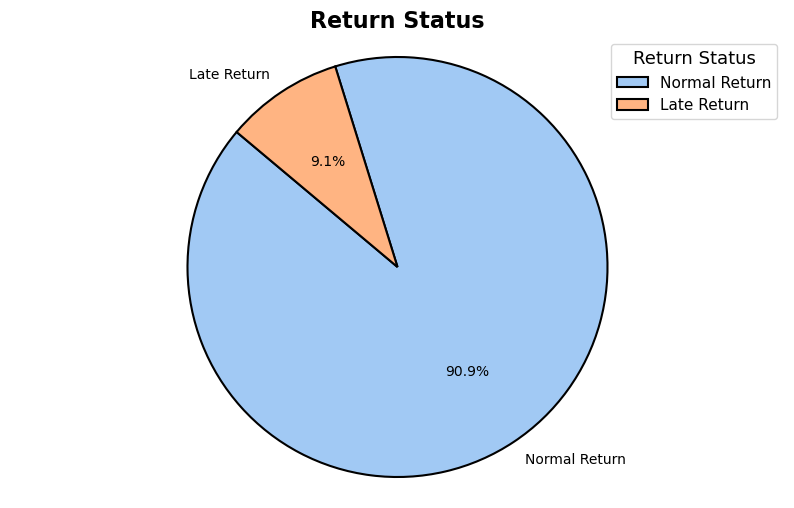

In [29]:
late_rate = valid_checkouts['late'].value_counts()

labels = ['Normal Return', 'Late Return'] if late_rate.index[0] == False else ['Late Return', 'Normal Return']

colors = sns.color_palette('pastel')


plt.figure(figsize=(10, 6))
plt.pie(late_rate.values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Return Status', fontsize=16, fontweight='bold')
plt.axis('equal')  


plt.legend(title='Return Status', title_fontsize='13', fontsize='11', loc='upper right')

plt.show()

In [30]:
valid_checkouts_old = valid_checkouts

# Merging process
valid_checkouts = valid_checkouts.merge(libraries, left_on='library_id', right_on='id', how='left')
valid_checkouts = valid_checkouts.merge(customers[['id', 'street_address','birth_date', 'gender', 'education', 'occupation']], left_on='patron_id', right_on='id', how='left')
valid_checkouts = valid_checkouts.merge(books[['id', 'categories', 'price', 'pages', 'publishedDate', 'publisher', 'authors']], left_on='id_x', right_on='id', how='left', suffixes=('_checkout', '_book'))

#Rename the merged street_address column to avoid confusion
valid_checkouts.rename(columns={'street_address': 'customer_street_address'}, inplace=True)

In [32]:
#Defining the clean_date function to extract the year
def clean_date(date_str):
    try:
        parsed_date = parser.parse(date_str, fuzzy=True)
        return parsed_date.year
    except (parser.ParserError, TypeError, ValueError):
        return None

valid_checkouts['publishedDate'] = valid_checkouts['publishedDate'].apply(clean_date).astype('Int64')


In [33]:
valid_checkouts['birth_date'] = pd.to_datetime(valid_checkouts['birth_date'], errors='coerce')


In [34]:
valid_checkouts = valid_checkouts[(valid_checkouts['birth_date'] > pd.to_datetime('1950-01-01'))&
                                   (valid_checkouts['birth_date'] < pd.to_datetime('2008-12-30'))]


In [35]:
# Reference date for age calculation (checkout date)
def calculate_age(birth_date, ref_date):
    return ref_date.year - birth_date.year - ((ref_date.month, ref_date.day) < (birth_date.month, birth_date.day))

valid_checkouts['age'] = valid_checkouts.apply(lambda row: calculate_age(row['birth_date'], row['date_checkout']), axis=1)


C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\2379820412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['age'] = valid_checkouts.apply(lambda row: calculate_age(row['birth_date'], row['date_checkout']), axis=1)


In [36]:
# Adding age_group column based on age
def age_group(age):
    if age <= 17:
        return 'young'
    elif 18 <= age <= 25:
        return 'youth'
    elif 26 <= age <= 35:
        return 'adult'
    elif 36 <= age <= 45:
        return 'middle-aged'
    elif age> 45:
        return 'senior'

valid_checkouts['age_group'] = valid_checkouts['age'].apply(age_group)

C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\2192350308.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['age_group'] = valid_checkouts['age'].apply(age_group)


Analayis of different factors for the case with late

In [38]:
# Factors associated with late returns
late_by_library = valid_checkouts.groupby('library_id')['late'].mean()
late_by_education = valid_checkouts.groupby('education')['late'].mean()
late_by_gender = valid_checkouts.groupby('gender')['late'].mean()
late_by_categories = valid_checkouts.groupby('categories')['late'].mean()
late_by_pages = valid_checkouts.groupby('pages')['late'].mean()
late_by_price = valid_checkouts.groupby('price')['late'].mean()
late_by_age_group = valid_checkouts.groupby('age_group')['late'].mean()
late_by_occupation = valid_checkouts.groupby('occupation')['late'].mean()
late_by_publishedDate = valid_checkouts.groupby('publishedDate')['late'].mean()
late_by_publisher = valid_checkouts.groupby('publisher')['late'].mean()
late_by_authors = valid_checkouts.groupby('authors')['late'].mean()
late_by_authors_count = valid_checkouts.groupby('authors')['late'].sum()


In [39]:
libraries.loc[libraries.id == late_by_library.index, 'name']

14    Multnomah  County Library Albina
Name: name, dtype: object

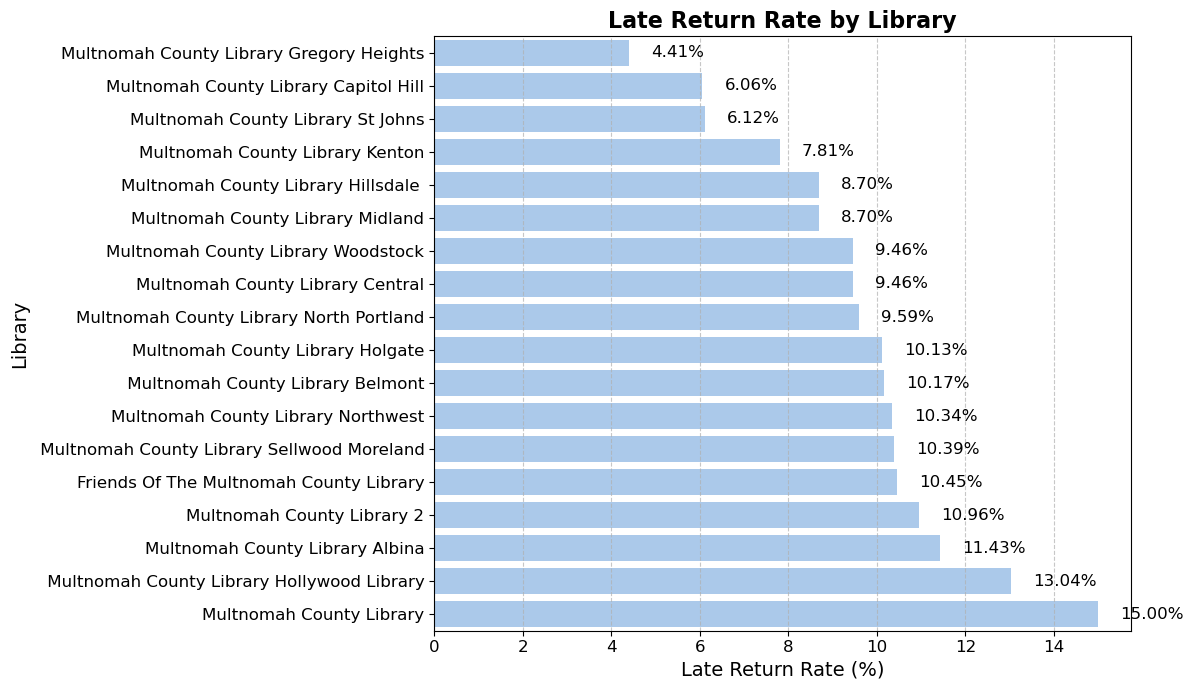

In [40]:
# Aligning and filtering libraries.id and late_by_library.index
filtered_libraries = libraries[libraries.id.isin(late_by_library.index)]

# Correcting capitalization and spacing
filtered_libraries['name'] = filtered_libraries['name'].str.replace(r'\s+', ' ', regex=True).str.title()

# Handling identical names by appending numbers
name_counts = {}
new_names = []
for name in filtered_libraries['name']:
    if name in name_counts:
        name_counts[name] += 1
        new_name = f"{name} {name_counts[name]}"
    else:
        name_counts[name] = 1
        new_name = name
    new_names.append(new_name)

filtered_libraries['name'] = new_names


filtered_libraries['late_return_rate'] = late_by_library[filtered_libraries.id].values * 100
sorted_libraries = filtered_libraries.sort_values(by='late_return_rate', ascending=True)

sns.set_palette('pastel')

plt.figure(figsize=(12, 7))
sns.barplot(y=sorted_libraries['name'], x=sorted_libraries['late_return_rate'])
plt.title('Late Return Rate by Library', fontsize=16, fontweight='bold')
plt.ylabel('Library', fontsize=14)
plt.xlabel('Late Return Rate (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(sorted_libraries['late_return_rate']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', ha='left', color='black', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [41]:
late_by_education

education
                   0.116667
College            0.107266
Graduate Degree    0.083650
High School        0.087500
Others             0.101399
Name: late, dtype: float64

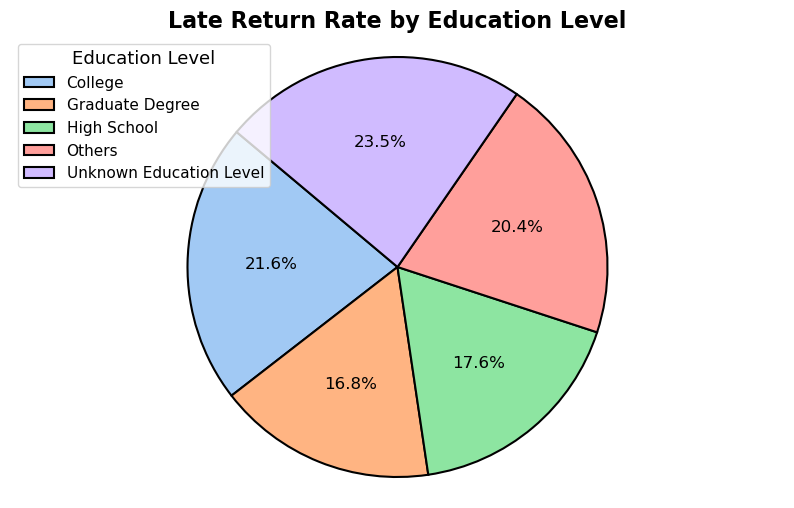

In [42]:
# Replacing blank values in late_by_education with Unknown Education Level
late_by_education.index = late_by_education.index.to_series().replace('', 'Unknown Education Level')

late_by_education = late_by_education.reindex(late_by_education.index.to_list()[1:] + ['Unknown Education Level'])

colors = sns.color_palette('pastel')

plt.figure(figsize=(10, 6))
plt.pie(late_by_education.values, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, textprops={'fontsize': 12})
plt.title('Late Return Rate by Education Level', fontsize=16, fontweight='bold')
plt.axis('equal')

plt.legend(labels=late_by_education.index, title='Education Level', title_fontsize='13', fontsize='11', loc='upper left')

plt.show()


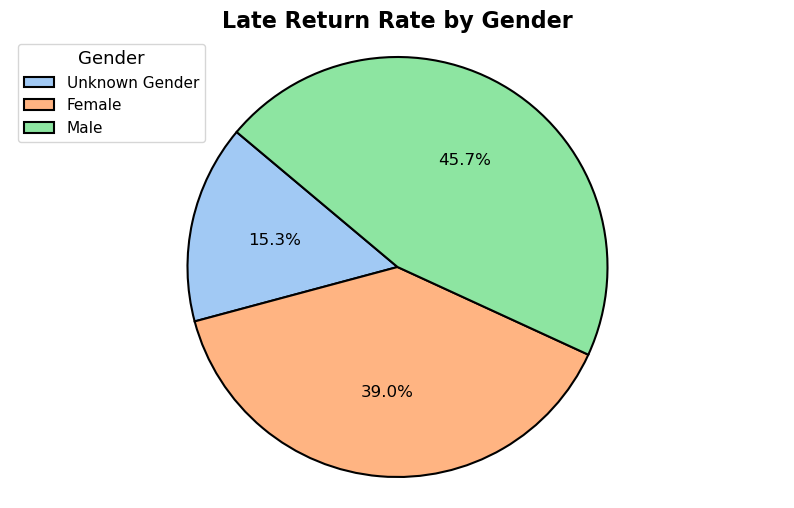

In [43]:
#Replacing blank values with 'Unknown Gender'
late_by_gender.index = late_by_gender.index.to_series().replace('', 'Unknown Gender')

colors = sns.color_palette('pastel')

plt.figure(figsize=(10, 6))
plt.pie(late_by_gender.values, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, textprops={'fontsize': 12})
plt.title('Late Return Rate by Gender', fontsize=16, fontweight='bold')
plt.axis('equal')

plt.legend(labels=late_by_gender.index, title='Gender', title_fontsize='13', fontsize='11', loc='upper left')

plt.show()

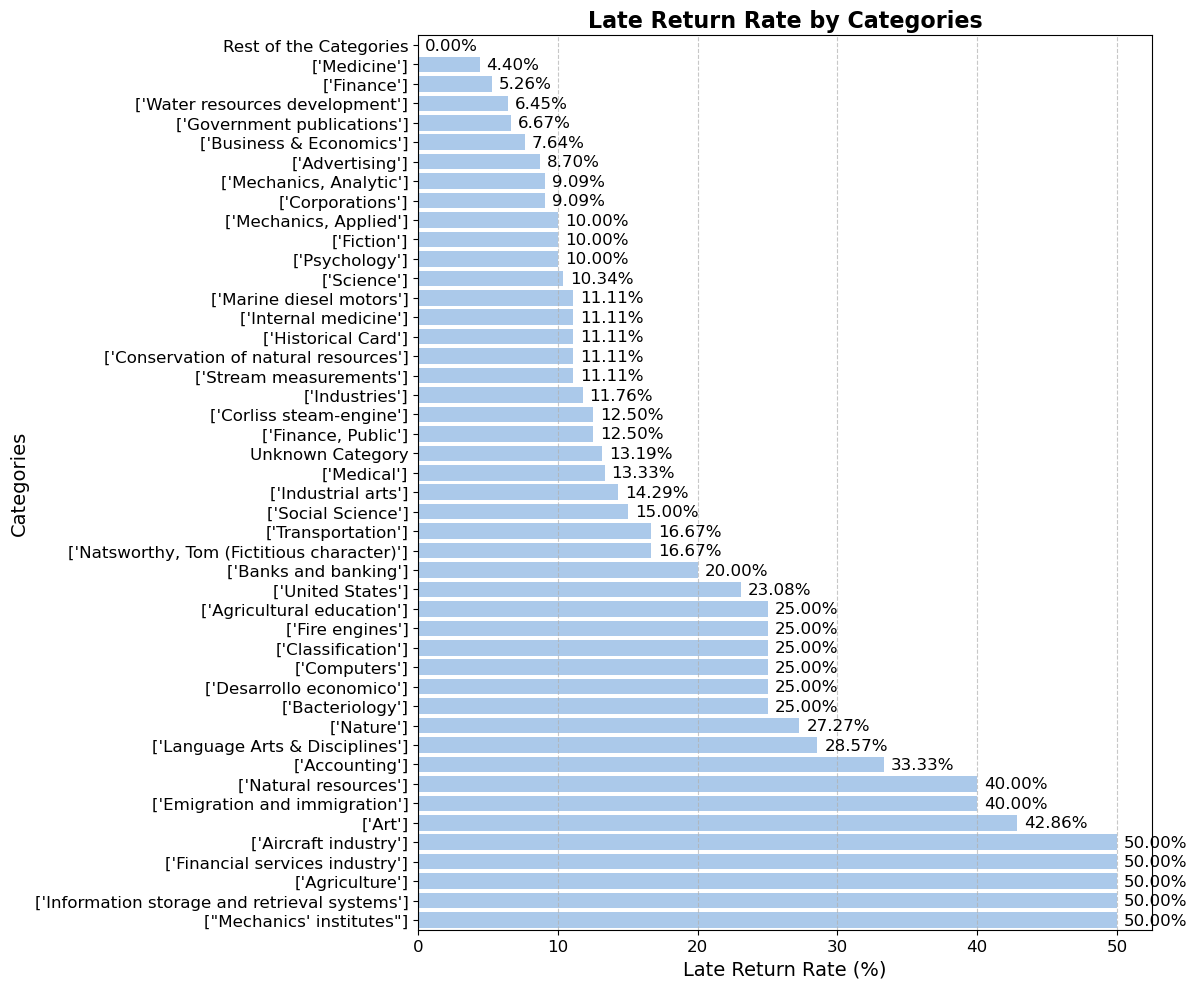

In [44]:
#Replacing blank categories with 'Unknown Category'
late_by_categories.index = late_by_categories.index.to_series().replace('', 'Unknown Category')

#Combining all categories with zero return rate into 'Rest of the Categories'
zero_return_categories = late_by_categories[late_by_categories == 0].index
late_by_categories_combined = late_by_categories.copy()
late_by_categories_combined = late_by_categories_combined[late_by_categories_combined > 0]
late_by_categories_combined['Rest of the Categories'] = 0

# Sorting the categories
sorted_late_by_categories = late_by_categories_combined.sort_values()

sns.set_palette('pastel')

plt.figure(figsize=(12, 10))
sns.barplot(y=sorted_late_by_categories.index, x=sorted_late_by_categories.values * 100)
plt.title('Late Return Rate by Categories', fontsize=16, fontweight='bold')
plt.xlabel('Late Return Rate (%)', fontsize=14)
plt.ylabel('Categories', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Adjust the x-axis text size
plt.yticks(fontsize=12)

for index, value in enumerate(sorted_late_by_categories.values * 100):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', ha='left', color='black', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


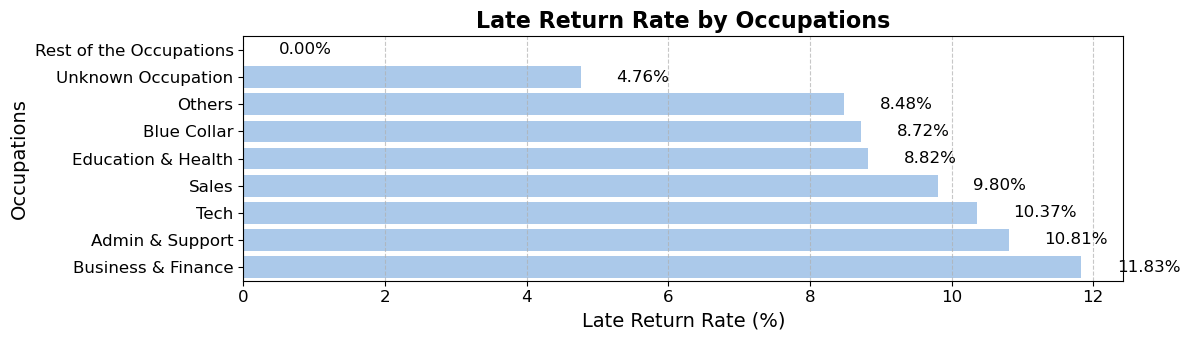

In [45]:
# Replacing blank values to'Unknown Occupation'
late_by_occupation.index = late_by_occupation.index.to_series().replace('', 'Unknown Occupation')

#Combining zero return rate into 'Rest of the Occupations
zero_return_occupations = late_by_occupation[late_by_occupation == 0].index
late_by_occupation_combined = late_by_occupation.copy()
late_by_occupation_combined = late_by_occupation_combined[late_by_occupation_combined > 0]
late_by_occupation_combined['Rest of the Occupations'] = 0

sorted_late_by_occupation = late_by_occupation_combined.sort_values()

sns.set_palette('pastel')

plt.figure(figsize=(12, 3.5))
sns.barplot(y=sorted_late_by_occupation.index, x=sorted_late_by_occupation.values * 100)
plt.title('Late Return Rate by Occupations', fontsize=16, fontweight='bold')
plt.xlabel('Late Return Rate (%)', fontsize=14)
plt.ylabel('Occupations', fontsize=14)
plt.xticks(rotation=0, fontsize=12) 
plt.yticks(fontsize=12)

for index, value in enumerate(sorted_late_by_occupation.values * 100):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', ha='left', color='black', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


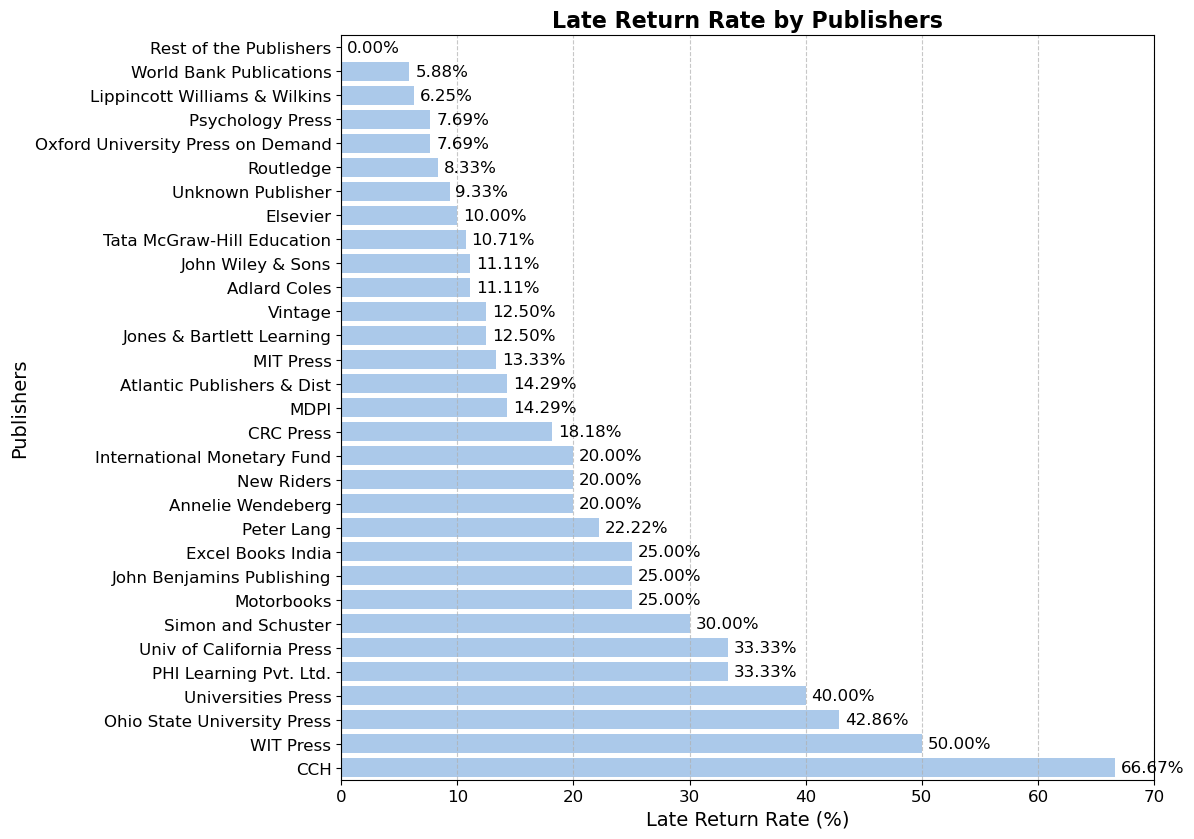

In [46]:
#Replacing blank values with "Unknown Publisher'
late_by_publisher.index = late_by_publisher.index.to_series().replace('', 'Unknown Publisher')

# Combining zero return rate into 'Rest of the Publishers'
zero_return_publishers = late_by_publisher[late_by_publisher == 0].index
late_by_publisher_combined = late_by_publisher.copy()
late_by_publisher_combined = late_by_publisher_combined[late_by_publisher_combined > 0]
late_by_publisher_combined['Rest of the Publishers'] = 0

sorted_late_by_publisher = late_by_publisher_combined.sort_values()

sns.set_palette('pastel')

plt.figure(figsize=(12, 8.5))
sns.barplot(y=sorted_late_by_publisher.index, x=sorted_late_by_publisher.values * 100)
plt.title('Late Return Rate by Publishers', fontsize=16, fontweight='bold')
plt.xlabel('Late Return Rate (%)', fontsize=14)
plt.ylabel('Publishers', fontsize=14)
plt.xticks(rotation=0, fontsize=12) 
plt.yticks(fontsize=12)

for index, value in enumerate(sorted_late_by_publisher.values * 100):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', ha='left', color='black', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

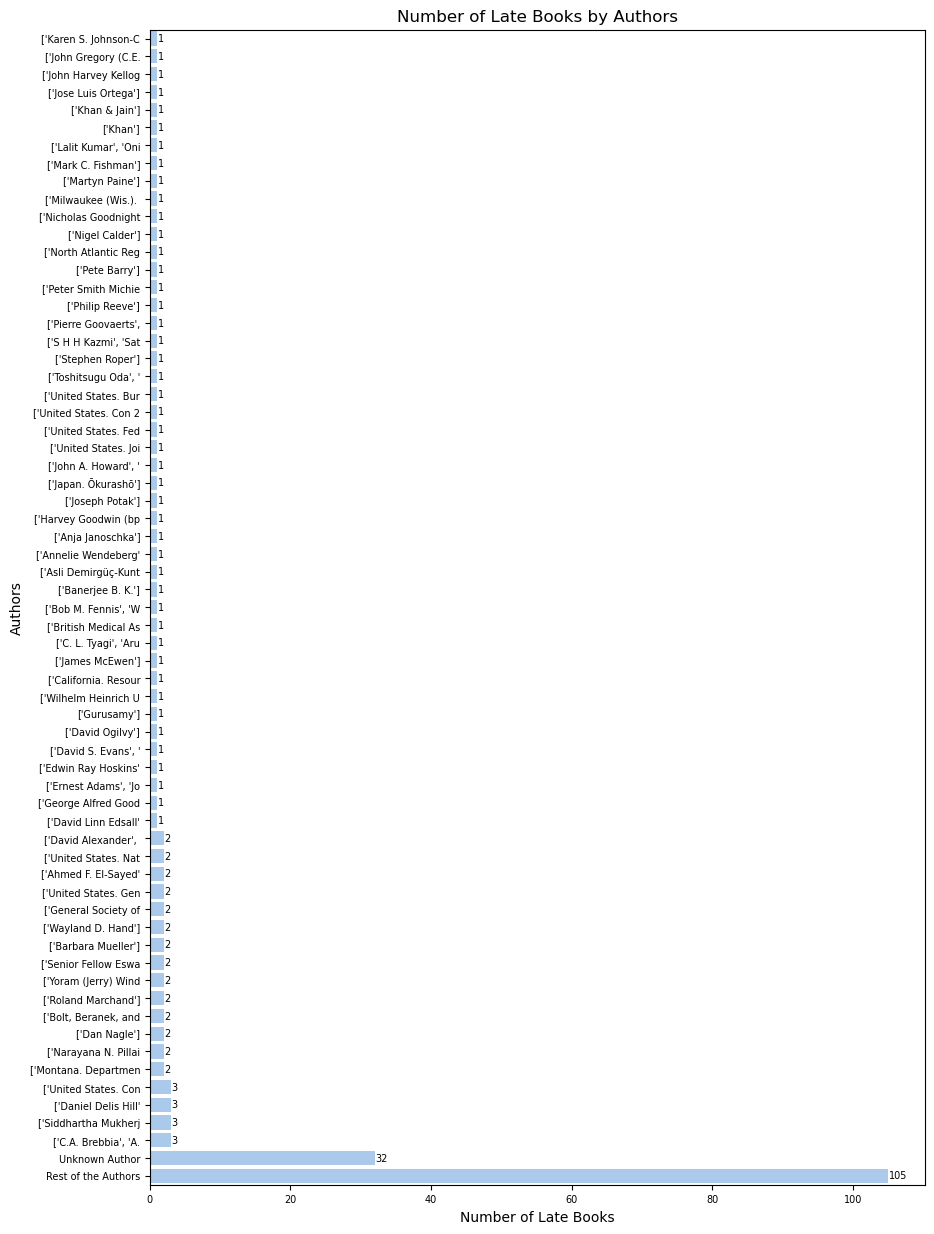

In [47]:
# Calculating True values count in the 'late' column for each author
late_by_authors_count = valid_checkouts.groupby('authors')['late'].sum()

# Replacing blank values in late_by_authors_count
late_by_authors_count.index = late_by_authors_count.index.to_series().replace('', 'Unknown Author')

# Combinin g authors with a zero late book count
zero_late_authors = late_by_authors_count[late_by_authors_count == 0].index
late_by_authors_count_combined = late_by_authors_count.copy()
late_by_authors_count_combined = late_by_authors_count_combined[late_by_authors_count_combined > 0]
late_by_authors_count_combined['Rest of the Authors'] = zero_late_authors.size

# Truncating the names of the authors to the first 20 characters
late_by_authors_count_combined.index = late_by_authors_count_combined.index.str[:20]

# Handling identical names
name_counts = {}
new_names = []
for name in late_by_authors_count_combined.index:
    if name in name_counts:
        name_counts[name] += 1
        new_name = f"{name} {name_counts[name]}"
    else:
        name_counts[name] = 1
        new_name = name
    new_names.append(new_name)

late_by_authors_count_combined.index = new_names

sorted_late_by_authors_count = late_by_authors_count_combined.sort_values()

plt.figure(figsize=(10, 15))
sns.barplot(y=sorted_late_by_authors_count.index, x=sorted_late_by_authors_count.values)
plt.title('Number of Late Books by Authors')
plt.xlabel('Number of Late Books')
plt.ylabel('Authors')
plt.xticks(rotation=0, fontsize=7)  
plt.yticks(fontsize=7)

for index, value in enumerate(sorted_late_by_authors_count.values):
    plt.text(value + 0.1, index, f'{value}', va='center', ha='left', color='black', fontsize=7)

plt.show()

In [48]:
late_by_age_group

age_group
adult          0.106280
middle-aged    0.063415
senior         0.109937
young          0.101796
youth          0.078313
Name: late, dtype: float64

In [105]:

age_group_order = ['Young', 'Youth', 'Adult', 'Middle-Aged', 'Senior']
late_by_age_group = late_by_age_group.reindex(age_group_order)

plt.figure(figsize=(10, 6))
plt.pie(late_by_age_group, labels=late_by_age_group.index, autopct='%1.1f%%', startangle=140)
plt.title('Late Return Rate by Age Group')
plt.show()

In [ ]:
age_group_order = ['young', 'youth', 'adult', 'middle-aged', 'senior']


late_by_age_gender = valid_checkouts[valid_checkouts['gender'].isin(['Female', 'Male'])].groupby(['age_group', 'gender'])['late'].mean().unstack().reindex(age_group_order)
late_by_age_group = valid_checkouts.groupby('age_group')['late'].mean().reindex(age_group_order)

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=late_by_age_group.index, y=late_by_age_group.values, palette='pastel')
bar_plot.set_label('')

colors = ['red', 'blue']
genders = ['Female', 'Male']
for idx, gender in enumerate(genders):
    gender_values = late_by_age_gender[gender].values
    sns.lineplot(x=late_by_age_gender.index, y=gender_values, marker='o', color=colors[idx], label=f'Late Return Rate - {gender}')

plt.title('Late Return Rate by Age Group and Gender', fontsize=16, fontweight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Late Return Rate', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='lower left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [50]:
valid_checkouts['publishedDate']

0       2006
1       2004
3       1997
4       1994
5       1924
        ... 
1442    2017
1443    1984
1447    2013
1449    1909
1450    1921
Name: publishedDate, Length: 1218, dtype: Int64

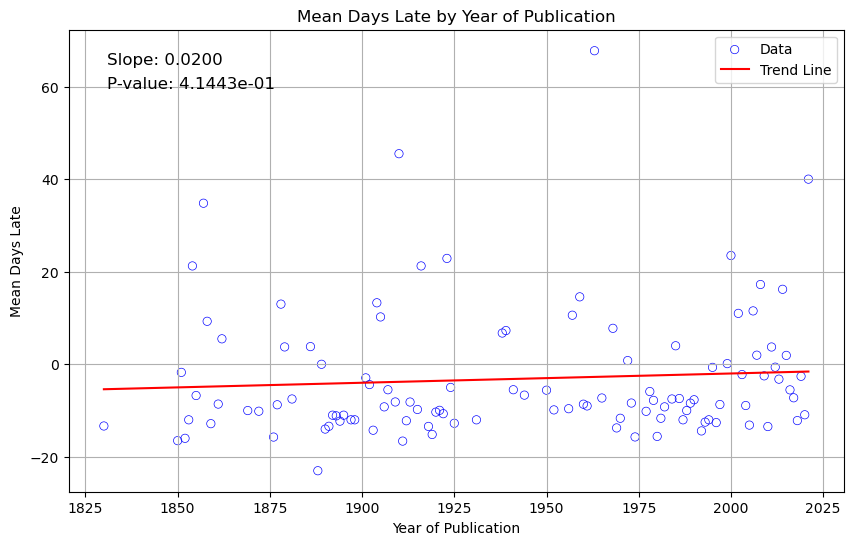

In [51]:
#Calculating the mean days late by year
days_late_by_publishedDate = valid_checkouts.groupby('publishedDate')['days_late'].mean()

days_late_by_publishedDate = days_late_by_publishedDate.sort_index()

#linear regression
slope, intercept, r_value, p_value, std_err = linregress(days_late_by_publishedDate.index, days_late_by_publishedDate.values)

trend_line = slope * days_late_by_publishedDate.index + intercept

plt.figure(figsize=(10, 6))
sns.scatterplot(x=days_late_by_publishedDate.index, y=days_late_by_publishedDate.values, marker='o', facecolors='none', edgecolor='b', label='Data')
plt.plot(days_late_by_publishedDate.index, trend_line, color='red', label='Trend Line')

plt.text(0.05, 0.95, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'P-value: {p_value:.4e}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title('Mean Days Late by Year of Publication')
plt.xlabel('Year of Publication')
plt.ylabel('Mean Days Late')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Cleaning numeric columns
def clean_numeric(value):
    clean_value = re.sub(r'[^0-9.]', '', str(value))
    return float(clean_value) if clean_value else None

valid_checkouts['price'] = valid_checkouts['price'].apply(clean_numeric)
valid_checkouts['pages'] = valid_checkouts['pages'].apply(clean_numeric)


C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\411149134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['price'] = valid_checkouts['price'].apply(clean_numeric)
C:\Users\iwont\AppData\Local\Temp\ipykernel_18264\411149134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_checkouts['pages'] = valid_checkouts['pages'].apply(clean_numeric)


+-----------+-----------------------+----------------------+-----------------------+----------------------+
|           |         price         |        pages         |          age          |      days_late       |
+-----------+-----------------------+----------------------+-----------------------+----------------------+
|   price   |          1.0          |  0.7394924782217739  | -0.029965754677136008 | 0.12087704673799822  |
|   pages   |   0.7394924782217739  |         1.0          |  -0.07259683945168265 | 0.17450072122842958  |
|    age    | -0.029965754677136008 | -0.07259683945168265 |          1.0          | 0.021005584666833315 |
| days_late |  0.12087704673799822  | 0.17450072122842958  |  0.021005584666833315 |         1.0          |
+-----------+-----------------------+----------------------+-----------------------+----------------------+


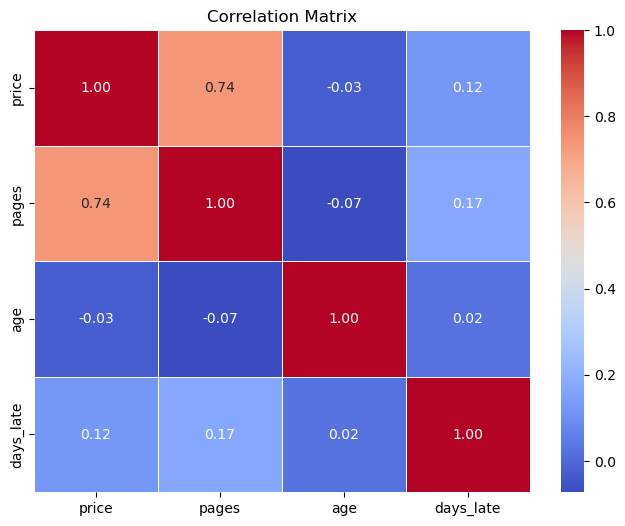

In [53]:
# correlation matrix
correlation_matrix = valid_checkouts[['price', 'pages', 'age', 'days_late']].corr()

table = PrettyTable()

table.field_names = [""] + list(correlation_matrix.columns)

for index, row in correlation_matrix.iterrows():
    table.add_row([index] + list(row))

print(table)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [54]:
# Filtering non-numeric columns
numeric_columns = valid_checkouts.select_dtypes(include=['number']).columns

# Set float format to avoid scientific notation
pd.options.display.float_format = '{:.3f}'.format

# ANOVA for numeric column vs age_group
anova_results = {}

for column in numeric_columns:
    subset_df = valid_checkouts[['age_group', column]].dropna()
    
    model = ols(f'{column} ~ C(age_group)', data=subset_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[column] = anova_table

for column, result in anova_results.items():
    print(f"ANOVA for {column}:\n{result}\n")

pd.reset_option('display.float_format')



ANOVA for days_late:
                  sum_sq       df     F  PR(>F)
C(age_group)    3079.448    4.000 0.815   0.515
Residual     1145148.690 1213.000   NaN     NaN

ANOVA for price:
                   sum_sq       df     F  PR(>F)
C(age_group)   128273.830    4.000 1.232   0.295
Residual     31252004.109 1201.000   NaN     NaN

ANOVA for pages:
                   sum_sq       df     F  PR(>F)
C(age_group)   260346.797    4.000 2.237   0.063
Residual     35208922.212 1210.000   NaN     NaN

ANOVA for publishedDate:
                  sum_sq       df     F  PR(>F)
C(age_group)    6227.159    4.000 0.577   0.679
Residual     3224537.261 1196.000   NaN     NaN

ANOVA for age:
                 sum_sq       df        F  PR(>F)
C(age_group) 321487.393    4.000 3867.659   0.000
Residual      25206.732 1213.000      NaN     NaN



In [55]:
libraries.loc[libraries.id == late_by_library.index, 'street_address']

14    3605 NE 15th Ave
Name: street_address, dtype: object

In [56]:
libraries = libraries.set_index('id').join(late_by_library)


In [57]:
# Geocode addresses to get latitude and longitude
geolocator = Nominatim(user_agent="library_map")
libraries['location'] = libraries['street_address'].apply(geolocator.geocode)
libraries['latitude'] = libraries['location'].apply(lambda loc: loc.latitude if loc else None)
libraries['longitude'] = libraries['location'].apply(lambda loc: loc.longitude if loc else None)

# Folium map
portland_coords = [45.523064, -122.676483]

m = folium.Map(location=portland_coords, zoom_start=11, width=800, height=600)

for idx, row in libraries.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        folium.Circle(
            location=(row['latitude'], row['longitude']),
            radius=row['late'] * 3000, 
            popup=f"{row['name']} - Late Return Rate: {row['late']*100:.1f}%",
            color='black',
            fill=True,
            fill_color='gray'
        ).add_to(m)
        folium.Marker(
            location=(row['latitude'], row['longitude']),
            popup=f"{row['name']} - Late Return Rate: {row['late']*100:.1f}%",
            icon=folium.DivIcon(html=f"""<div style="font-size: 11pt; color : black">{row['late']*100:.1f}%</div>""")
        ).add_to(m)
m.save('library_late_return_rate_map.html')

m


In [58]:
valid_checkouts.to_csv('checkouts_cleaned.csv', index=False)


In [60]:
customers['street_address']

0                44 NE Meikle Pl
1            7511 SE Harrison St
2                1404 SE Pine St
3           12271 N Westshore Dr
4            5321 NE Skyport Way
                  ...           
1995    7331 NE Killingsworth St
1996       1908 NW Harborside Dr
1997             22 NE graham ST
1998         7000 NE Airport Way
1999             8993 SE 78th Pl
Name: street_address, Length: 2000, dtype: object

In [61]:
geolocator = Nominatim(user_agent="library_map")
libraries['location'] = libraries['street_address'].apply(geolocator.geocode)
libraries['latitude'] = libraries['location'].apply(lambda loc: loc.latitude if loc else None)
libraries['longitude'] = libraries['location'].apply(lambda loc: loc.longitude if loc else None)


In [63]:
customer_latitudes = []
customer_longitudes = []
counter = 0

for address in customers['street_address']:
    try:
        if not pd.isnull(address):
            location = geolocator.geocode(address)
            if location:
                customer_latitudes.append(location.latitude)
                customer_longitudes.append(location.longitude)
            else:
                customer_latitudes.append(None)
                customer_longitudes.append(None)
        else:
            customer_latitudes.append(None)
            customer_longitudes.append(None)
        counter += 1
        #print(f"Processed {counter} out of {len(customers)} addresses")
        time.sleep(1)  
    except Exception as e:
       # print(f"Error processing address: {address} - {e}")
        customer_latitudes.append(None)
        customer_longitudes.append(None)
        counter += 1
        continue



In [64]:
customers['longitude'] = customer_longitudes
customers['latitude'] = customer_latitudes

In [66]:
customers.to_csv('customers_map.csv', index=False)

In [67]:
#valid_checkouts = valid_checkouts.iloc[:, :-25]

In [73]:
#customer_latitudes and customer_longitudes

valid_checkouts = valid_checkouts.merge(customers[['id', 'latitude', 'longitude']], left_on='patron_id', right_on='id', how='left', suffixes=('', '_customer2'))


In [69]:
valid_checkouts = valid_checkouts.merge(libraries, left_on='library_id', right_on='id', how='left',suffixes=('', '_lib2'))


In [76]:
valid_checkouts.to_csv('valid_checkouts_map1.csv', index=False)

In [78]:
valid_checkouts.dropna(subset=['latitude_lib2', 'longitude_lib2', 'latitude_customer2', 'longitude_customer2'], inplace=True)

# Define a function to calculate geodesic distance
def calculate_distance(row):
    lib_coords = (row['latitude_lib2'], row['longitude_lib2'])
    customer_coords = (row['latitude_customer2'], row['longitude_customer2'])
    return geodesic(lib_coords, customer_coords).kilometers

# Apply the function to each row
valid_checkouts['distance'] = valid_checkouts.apply(calculate_distance, axis=1)

print(valid_checkouts)

              id_x                         patron_id           library_id  \
0     HUX-y4oXl04C  8d3f63e1deed89d7ba1bf6a4eb101373  223-222@5xc-jxr-tgk   
1     TQpFnkku2poC  4ae202f8de762591734705e0079d76df  228-222@5xc-jtz-hwk   
2     CW-7tHAaVR0C  dd9f34e9d65126a2b02003d8ac60aaa4  22c-222@5xc-jwj-pvz   
3     t1e3BWziAc8C  3b85b2c7b424618f533329018e9a11d5  222-222@5xc-jv5-nt9   
4     2mtCAAAAYAAJ  365ab35282c5d61b319ff9cc3628e624  228-222@5xc-jtz-hwk   
...            ...                               ...                  ...   
1213  1_1OtAEACAAJ  250a35a5fcef683b655097c5b8faae0c  223-222@5xc-jxr-tgk   
1214  TH8SSrWcVQ4C  6e58a20b8fe97c5f73815046be1c41df  23v-222@5xc-jv7-v4v   
1215  rcrCAgAAQBAJ  ad08956eb20efb746af650f906d439cf  22d-222@5xc-kcy-8sq   
1216  Ci1HAQAAMAAJ  08b29865e58e9b2aabff9684a703acf0  223-222@5xc-jxr-tgk   
1217  TUAyAQAAMAAJ  ac0bb7b22b4df999a0b1216ded727f8e  228-222@5xc-jtz-hwk   

     date_checkout date_returned  days_late   late                 id_y  \


+-----------+-----------------------+-----------------------+----------------------+----------------------+-----------------------+
|           |         price         |         pages         |         age          |      days_late       |        distance       |
+-----------+-----------------------+-----------------------+----------------------+----------------------+-----------------------+
|   price   |          1.0          |   0.7394523326994247  | -0.0263750303767715  | 0.11649601281325586  | -0.022574762775430128 |
|   pages   |   0.7394523326994247  |          1.0          | -0.06595051794621334 | 0.17689358792349066  | -0.051881101384048535 |
|    age    |  -0.0263750303767715  |  -0.06595051794621334 |         1.0          | 0.01787344732463344  |  0.013512383801023011 |
| days_late |  0.11649601281325586  |  0.17689358792349066  | 0.01787344732463344  |         1.0          |  0.009698952795393645 |
|  distance | -0.022574762775430128 | -0.051881101384048535 | 0.013512383801

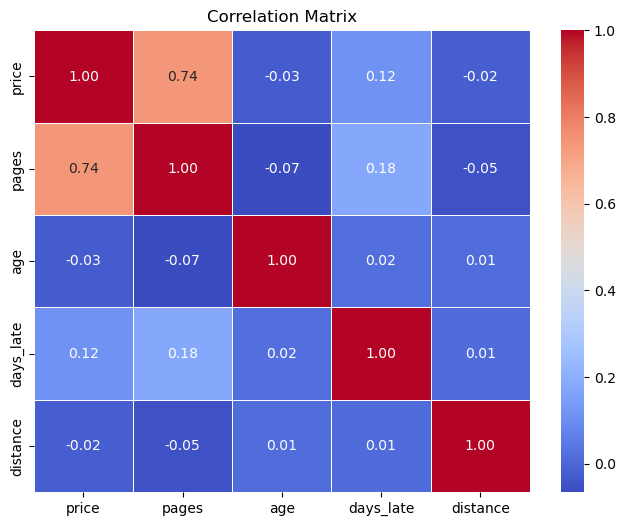

In [79]:
correlation_matrix = valid_checkouts[['price', 'pages', 'age', 'days_late','distance']].corr()

table = PrettyTable()

table.field_names = [""] + list(correlation_matrix.columns)

for index, row in correlation_matrix.iterrows():
    table.add_row([index] + list(row))

print(table)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [85]:
late_by_distance = valid_checkouts.groupby('distance')['late'].mean()


In [82]:
# Folium map
portland_coords = [45.523064, -122.676483]

m = folium.Map(location=portland_coords, zoom_start=11, width=800, height=600)

for idx, row in customers.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        folium.Circle(
            location=(row['latitude'], row['longitude']),
            radius= 10,  
            #popup=f"{row['name']} - Late Return Rate: {row['late']*100:.1f}%",
            color='black',
            fill=True,
            fill_color='gray'
        ).add_to(m)
        folium.Marker(
            location=(row['latitude'], row['longitude']),
            #popup=f"{row['name']} - Late Return Rate: {row['late']*100:.1f}%",
            icon=folium.DivIcon(html=f"""<div style="font-size: 11pt; color : black"></div>""")
        ).add_to(m)

m.save('library_late_return_rate_map.html')

m


In [311]:
portland_coords = [45.523064, -122.676483]
m = folium.Map(location=portland_coords, zoom_start=11.3, width=800, height=600)

# Heatmap
heat_data = []
for idx, row in customers.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        heat_data.append([row['latitude'], row['longitude']])

HeatMap(heat_data, radius=15, min_opacity=0.2, max_zoom=5).add_to(m)

for idx, row in libraries.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        folium.Marker(
            location=(row['latitude'], row['longitude']),
            popup=f"{row['name']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

m.save('library_late_return_rate_heatmap.html')

m


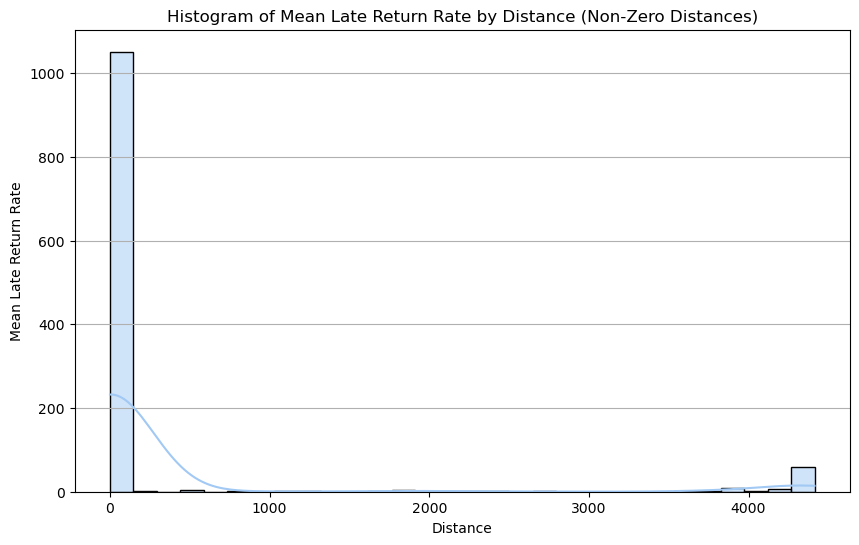

In [93]:
# Filter out rows where distance is zero
late_by_distance_non_zero = late_by_distance[late_by_distance['distance'] > 0]

# Plot the histogram for non-zero distances
plt.figure(figsize=(10, 6))
sns.histplot(late_by_distance_non_zero, x='distance', bins=30, kde=True)

plt.title('Histogram of Mean Late Return Rate by Distance (Non-Zero Distances)')
plt.xlabel('Distance')
plt.ylabel('Mean Late Return Rate')
# plt.ylim(1, 1.05)  # Limiting the y-axis between 1 and 1.05
plt.grid(axis='y')
plt.show()



In [95]:
valid_checkouts['checkout_year'] = valid_checkouts['date_checkout'].dt.year


In [96]:
valid_checkouts['checkout_month'] = valid_checkouts['date_checkout'].dt.month


In [97]:
# Adding a function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

valid_checkouts['season'] = valid_checkouts['checkout_month'].apply(get_season)

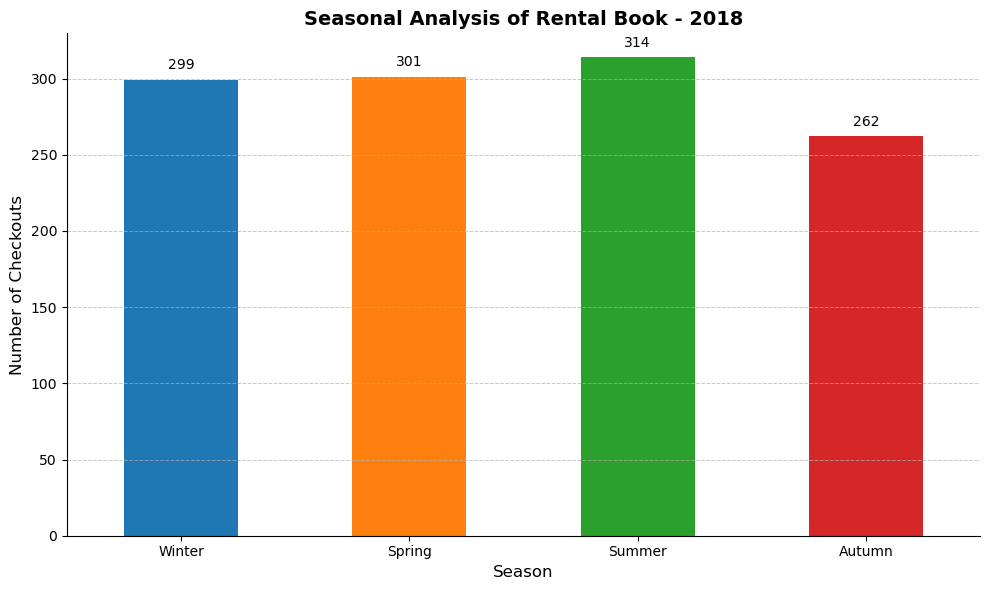

In [98]:
valid_checkouts_2018 = valid_checkouts[valid_checkouts['checkout_year'] == 2018]

seasonal_counts_2018 = valid_checkouts_2018.groupby('season').size().reindex(['Winter', 'Spring', 'Summer', 'Autumn']).fillna(0)

plt.figure(figsize=(10, 6))
seasonal_counts_2018.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('Seasonal Analysis of Rental Book - 2018', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Checkouts', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for index, value in enumerate(seasonal_counts_2018):
    plt.text(index, value + 5, str(int(value)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

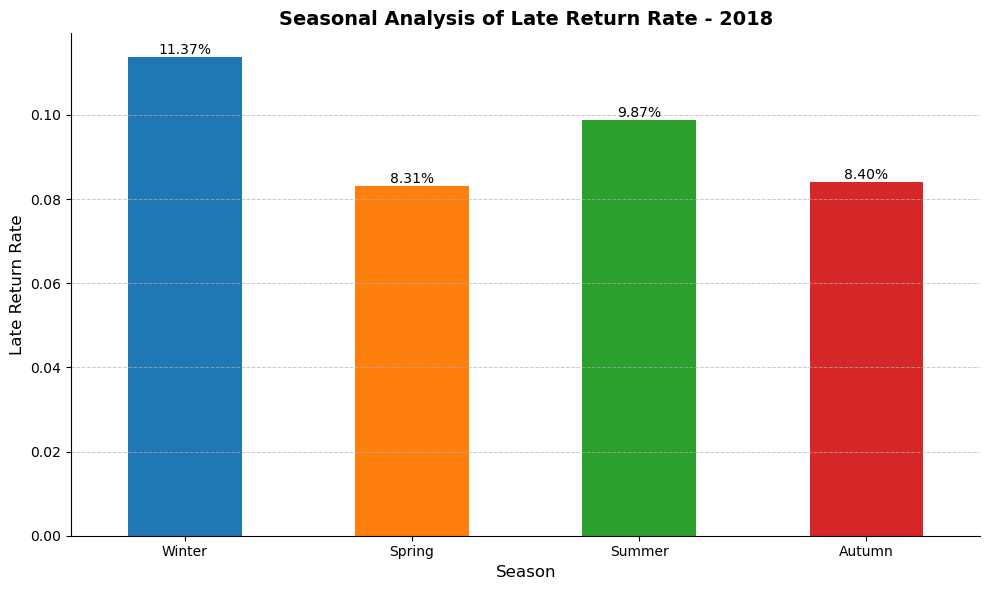

In [99]:

valid_checkouts_2018 = valid_checkouts[valid_checkouts['checkout_year'] == 2018]

seasonal_late_rate_2018 = valid_checkouts_2018.groupby('season')['late'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn']).fillna(0)

plt.figure(figsize=(10, 6))
seasonal_late_rate_2018.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('Seasonal Analysis of Late Return Rate - 2018', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Late Return Rate', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for index, value in enumerate(seasonal_late_rate_2018):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()


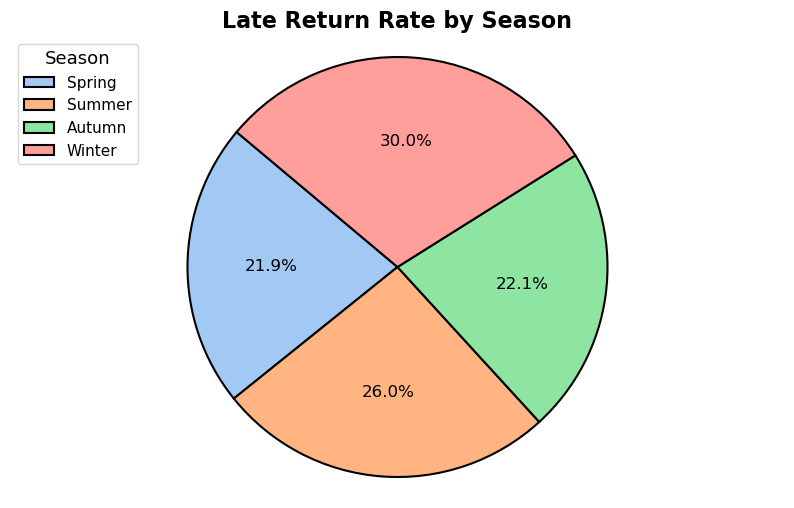

In [100]:
late_by_season = valid_checkouts.groupby('season')['late'].mean()

season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
late_by_season = late_by_season.reindex(season_order)

colors = sns.color_palette('pastel')

plt.figure(figsize=(10, 6))
plt.pie(late_by_season.values, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, textprops={'fontsize': 12})
plt.title('Late Return Rate by Season', fontsize=16, fontweight='bold')
plt.axis('equal')  

plt.legend(labels=late_by_season.index, title='Season', title_fontsize='13', fontsize='11', loc='upper left')

plt.show()


Epoch [10/128], Loss: 11.3560
Epoch [20/128], Loss: 54.8689
Epoch [30/128], Loss: 43.9367
Epoch [40/128], Loss: 50.2664
Epoch [50/128], Loss: 302.5875
Epoch [60/128], Loss: 125.4674
Epoch [70/128], Loss: 11281.9717
Epoch [80/128], Loss: 318.4840
Epoch [90/128], Loss: 182.4359
Epoch [100/128], Loss: 863.1839
Epoch [110/128], Loss: 51.4557
Epoch [120/128], Loss: 297.3916


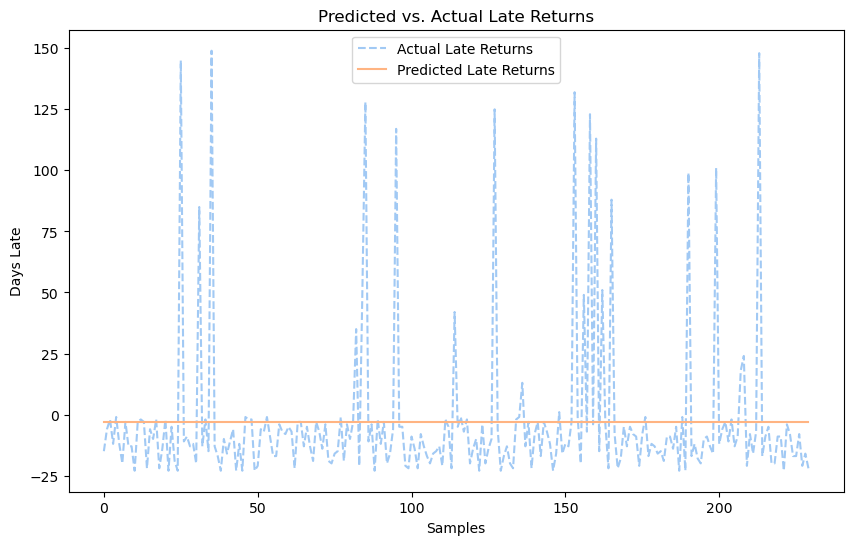

In [102]:
# Year extraction from publishedDate column
valid_checkouts['publishedYear'] = valid_checkouts['publishedDate'].apply(lambda x: pd.to_datetime(x, errors='coerce').year)

label_encoders = {}
categorical_columns = ['education', 'gender']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    valid_checkouts[column] = label_encoders[column].fit_transform(valid_checkouts[column].astype(str))

#Removing rows with NaN values
valid_checkouts.dropna(subset=['education', 'gender', 'pages', 'price', 'age', 'publishedYear', 'distance', 'days_late'], inplace=True)

X = valid_checkouts[['education', 'gender', 'pages', 'price', 'age', 'publishedYear', 'distance']]

Y = valid_checkouts['days_late']

# Standardization using Min Max scaler 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

#PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).view(-1, 1)

#ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

model = ANN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Learning rate

num_epochs = 128
batch_size = 2
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    Y_pred = model(X_test_tensor)

plt.figure(figsize=(10, 6))
plt.plot(Y_test_tensor.numpy(), label='Actual Late Returns', linestyle='dashed')
plt.plot(Y_pred.numpy(), label='Predicted Late Returns', linestyle='solid')
plt.title('Predicted vs. Actual Late Returns')
plt.xlabel('Samples')
plt.ylabel('Days Late')
plt.legend()
plt.show()


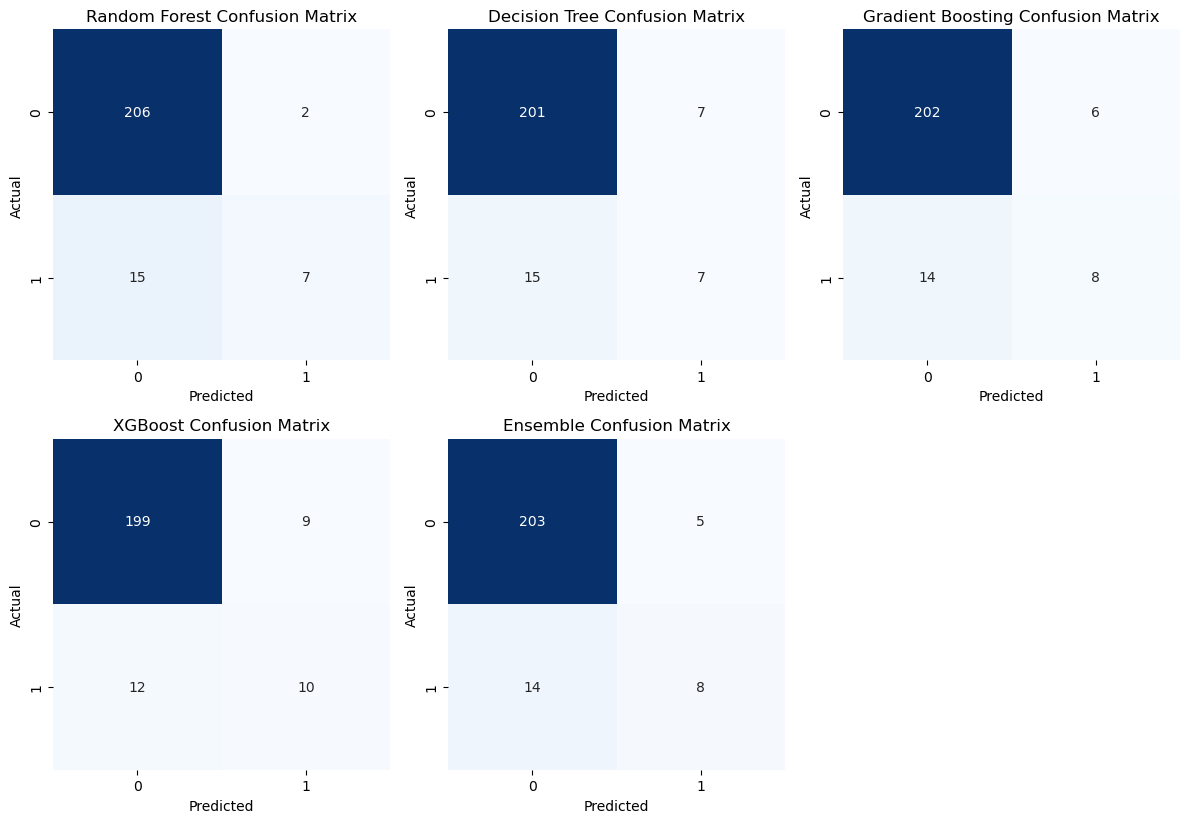

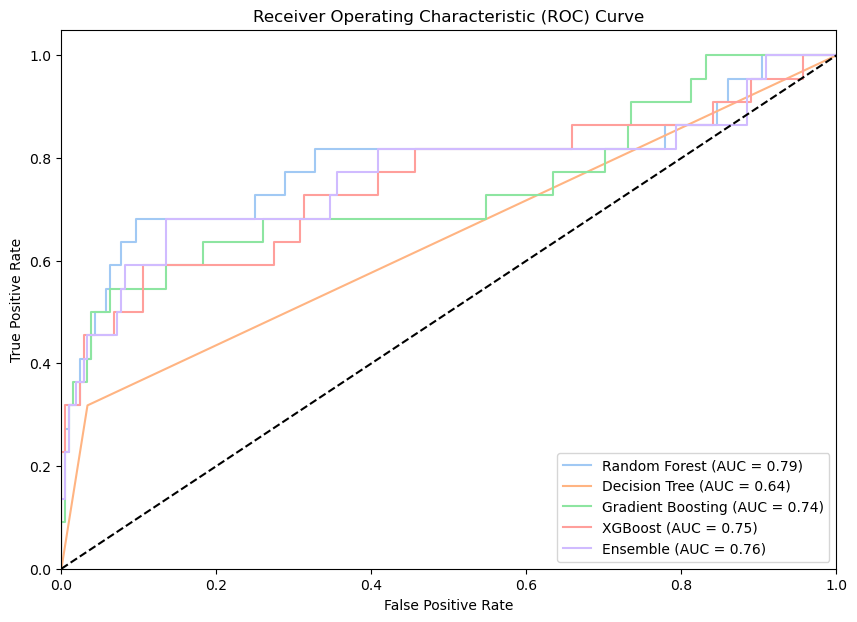

          Classifier  Accuracy  Sensitivity  Precision  F1 Score  Specificity
0      Random Forest  0.926087     0.318182   0.777778  0.451613     0.990385
1      Decision Tree  0.904348     0.318182   0.500000  0.388889     0.966346
2  Gradient Boosting  0.913043     0.363636   0.571429  0.444444     0.971154
3            XGBoost  0.908696     0.454545   0.526316  0.487805     0.956731
4           Ensemble  0.917391     0.363636   0.615385  0.457143     0.975962


In [103]:

valid_checkouts['publishedYear'] = valid_checkouts['publishedDate'].apply(lambda x: pd.to_datetime(x, errors='coerce').year)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['education', 'gender']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    valid_checkouts[column] = label_encoders[column].fit_transform(valid_checkouts[column].astype(str))

valid_checkouts.dropna(subset=['education', 'gender', 'pages', 'price', 'age', 'publishedYear', 'distance', 'late'], inplace=True)

X = valid_checkouts[['education', 'gender', 'pages', 'price', 'age', 'publishedYear', 'distance']]
Y = valid_checkouts['late'].astype(int)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_features='sqrt', min_samples_split=10, random_state=50),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=50),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=50)
}


ensemble_clf = VotingClassifier(estimators=list(classifiers.items()), voting='soft')

metrics = {'Classifier': [], 'Accuracy': [], 'Sensitivity': [], 'Precision': [], 'F1 Score': [], 'Specificity': []}

plt.figure(figsize=(12, 12))
for i, (name, clf) in enumerate({**classifiers, 'Ensemble': ensemble_clf}.items(), start=1):
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    plt.subplot(3, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    metrics['Classifier'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['Sensitivity'].append(sensitivity)
    metrics['Precision'].append(precision)
    metrics['F1 Score'].append(f1_score)
    metrics['Specificity'].append(specificity)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
for name, clf in {**classifiers, 'Ensemble': ensemble_clf}.items():
    clf.fit(X_train, Y_train)
    Y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


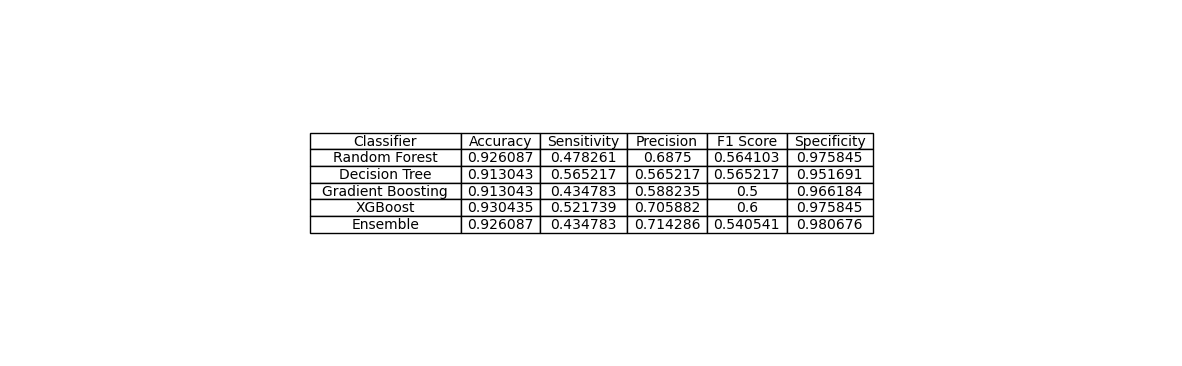

In [104]:
data = {
    'Classifier': ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'Ensemble'],
    'Accuracy': [0.926087, 0.913043, 0.913043, 0.930435, 0.926087],
    'Sensitivity': [0.478261, 0.565217, 0.434783, 0.521739, 0.434783],
    'Precision': [0.687500, 0.565217, 0.588235, 0.705882, 0.714286],
    'F1 Score': [0.564103, 0.565217, 0.500000, 0.600000, 0.540541],
    'Specificity': [0.975845, 0.951691, 0.966184, 0.975845, 0.980676]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(15, 4.5))  # Set figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.show()
